<a href="https://colab.research.google.com/github/dangalmar/TFG_Imagenes_Medicas/blob/main/Tratamiento_de_datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

In [2]:
folder_benign_train = '../../new_data/train/benign'
folder_malignant_train = '../../new_data/train/malignant'

folder_benign_test = '../../new_data/test/benign'
folder_malignant_test = '../../new_data/test/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


# Merge data
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

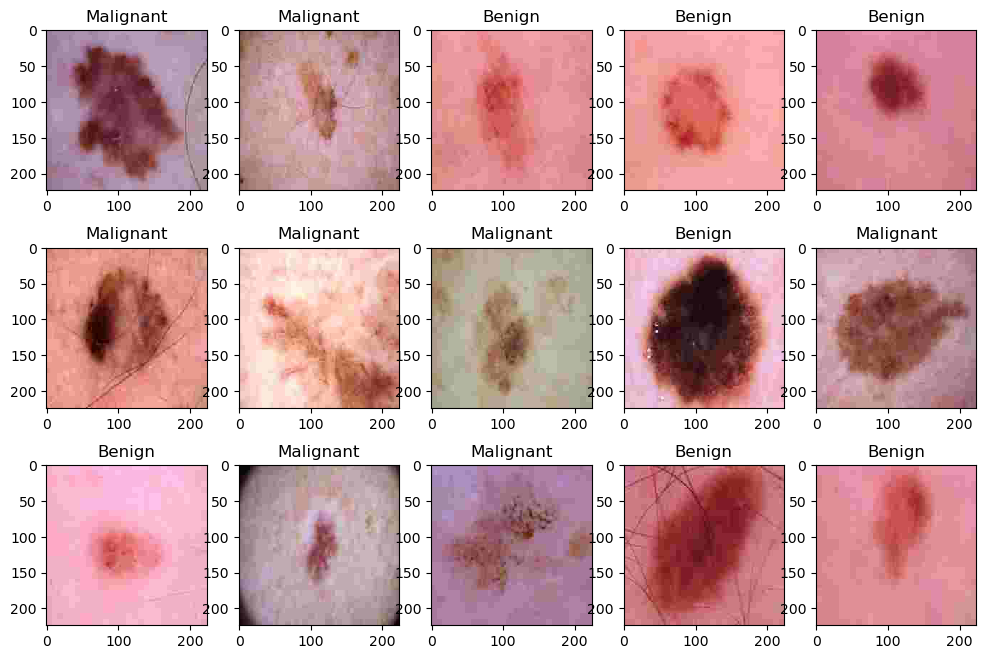

In [3]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')

plt.show()

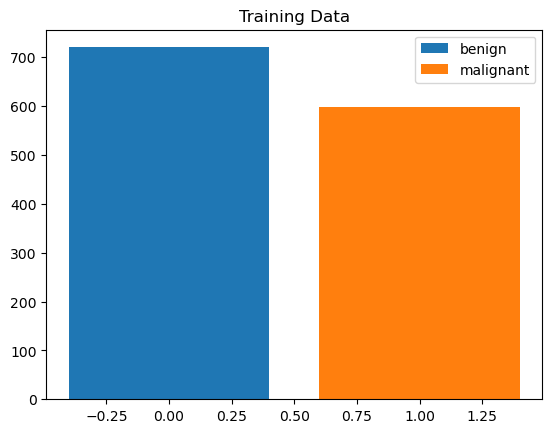

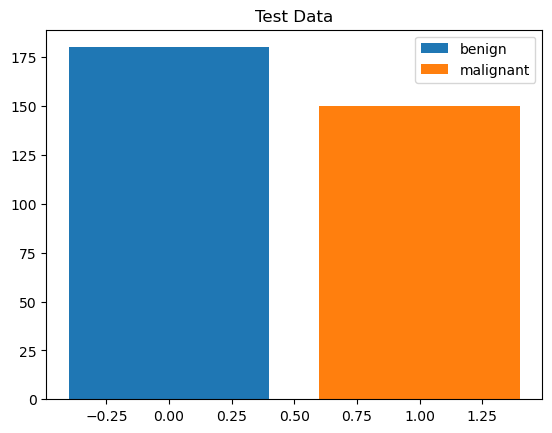

In [4]:
plt.bar(0, y_train[np.where(y_train == 0)].shape[0], label = 'benign')
plt.bar(1, y_train[np.where(y_train == 1)].shape[0], label = 'malignant')
plt.legend()
plt.title("Training Data")
plt.show()

plt.bar(0, y_test[np.where(y_test == 0)].shape[0], label = 'benign')
plt.bar(1, y_test[np.where(y_test == 1)].shape[0], label = 'malignant')
plt.legend()
plt.title("Test Data")
plt.show()

In [15]:
import tensorflow as tf
from keras.applications import ResNet152
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

In [16]:
from keras.preprocessing.image import ImageDataGenerator

# Crear un generador de aumento de datos para las imágenes de entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalizar los valores de píxeles
    rotation_range=40,          # Rango de rotación aleatorio
    width_shift_range=0.2,      # Desplazamiento horizontal aleatorio
    height_shift_range=0.2,     # Desplazamiento vertical aleatorio
    shear_range=0.2,            # Distorsión de cizalla aleatoria
    zoom_range=0.2,             # Zoom aleatorio
    horizontal_flip=True,       # Volteo horizontal aleatorio
    fill_mode='nearest'         # Modo de relleno para los píxeles que faltan después de la transformación
)

# Crear un generador de aumento de datos para las imágenes de validación (solo normalización)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Configurar los generadores de flujo de datos
train_generator = train_datagen.flow(
    X_train, y_train,           # Datos de entrenamiento
    batch_size=32              # Tamaño del lote
)

validation_generator = validation_datagen.flow(
    X_test, y_test,             # Datos de validación
    batch_size=32
)


In [17]:
base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])



234698864/234698864 [==============================] - 126s 1us/step


In [18]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_annealer = ReduceLROnPlateau(monitor='val_acc',mode='max',
                                          patience=3,
                                          verbose=1,
                                          factor=0.5,
                                          min_lr = 1e-4)


history = model.fit(train_generator,
                    steps_per_epoch=len(X_train) // 32,
                    validation_split=0.2,
                    epochs=20,
                    batch_size = 64,
                    verbose=1,
                    callbacks=[learning_rate_annealer],
                    validation_data=validation_generator,
                    validation_steps=len(X_test) // 32 )



print(history.history.keys())
model.save('resnet152_trained_with_data_augmentation_and_adam.h5')

Epoch 1/20
41/41 [==============================] - 224s 5s/step - loss: 1.6300 - accuracy: 0.5358 - val_loss: 0.6925 - val_accuracy: 0.5406 - lr: 0.0010
Epoch 2/20
41/41 [==============================] - 226s 6s/step - loss: 0.7006 - accuracy: 0.5474 - val_loss: 0.6915 - val_accuracy: 0.5594 - lr: 0.0010
Epoch 3/20
41/41 [==============================] - 232s 6s/step - loss: 0.6971 - accuracy: 0.5389 - val_loss: 0.6914 - val_accuracy: 0.5469 - lr: 0.0010
Epoch 4/20
41/41 [==============================] - 230s 6s/step - loss: 0.6924 - accuracy: 0.5397 - val_loss: 0.6911 - val_accuracy: 0.5437 - lr: 0.0010
Epoch 5/20
41/41 [==============================] - 231s 6s/step - loss: 0.6928 - accuracy: 0.5451 - val_loss: 0.6906 - val_accuracy: 0.5469 - lr: 0.0010
Epoch 6/20
41/41 [==============================] - 231s 6s/step - loss: 0.6906 - accuracy: 0.5459 - val_loss: 0.6901 - val_accuracy: 0.5500 - lr: 0.0010
Epoch 7/20
41/41 [==============================] - 230s 6s/step - loss: 0.7

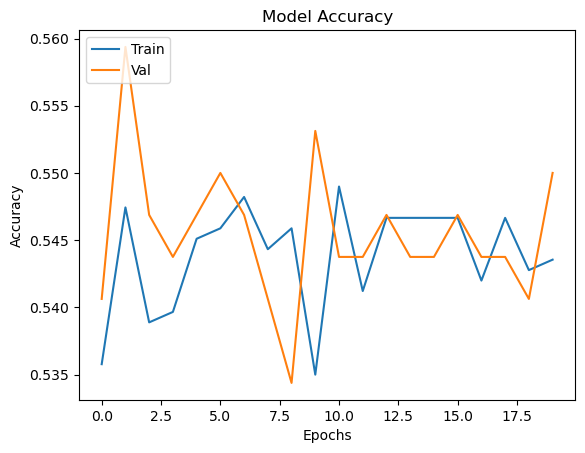

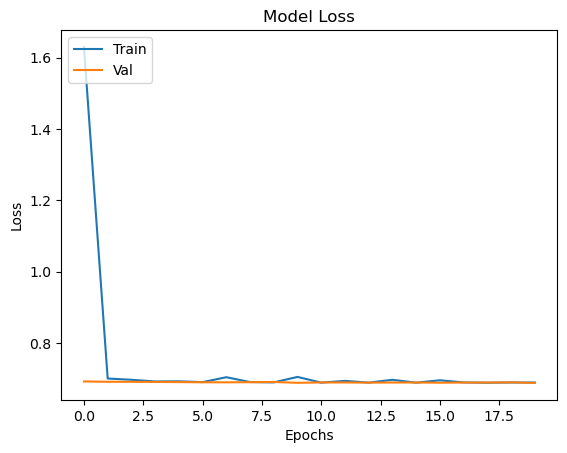

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

11/11 [==============================] - 44s 4s/step


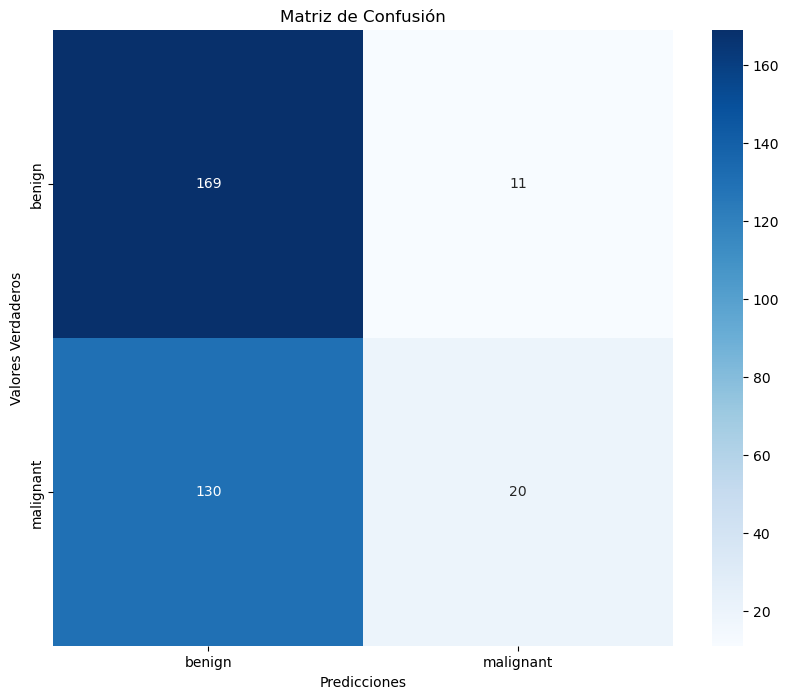

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_test_labels = ['benign' if label == 0 else 'malignant' for label in y_test]
y_pred_labels = ['benign' if label < 0.5 else 'malignant' for label in y_pred]

conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['benign', 'malignant'], 
            yticklabels=['benign', 'malignant'])
plt.title("Matriz de Confusión")
plt.xlabel("Predicciones")
plt.ylabel("Valores Verdaderos")
plt.show()